In [133]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init

n_labels = 10
cuda = torch.cuda.is_available()
device = "cuda:0" if cuda else "cpu"

def onehot(k):
    """
    Converts a number to its one-hot or 1-of-k representation
    vector.
    :param k: (int) length of vector
    :return: onehot function
    """
    def encode(label):
        y = torch.zeros(k)
        if label < k:
            y[label] = 1
        return y
    return encode

def get_mnist(location="./", batch_size=64, labels_per_class=100):
    from functools import reduce
    from operator import __or__
    from torch.utils.data.sampler import SubsetRandomSampler
    from torchvision.datasets import MNIST
    import torchvision.transforms as transforms

    flatten_bernoulli = lambda x: transforms.ToTensor()(x).view(-1).bernoulli()

    mnist_train = MNIST(location, train=True, download=True,
                        transform=flatten_bernoulli, target_transform=onehot(n_labels))
    mnist_valid = MNIST(location, train=False, download=True,
                        transform=flatten_bernoulli, target_transform=onehot(n_labels))

    def get_sampler(labels, n=None):
        # Only choose digits in n_labels
        (indices,) = np.where(reduce(__or__, [labels == i for i in np.arange(n_labels)]))

        # Ensure uniform distribution of labels
        np.random.shuffle(indices)
        indices = np.hstack([list(filter(lambda idx: labels[idx] == i, indices))[:n] for i in range(n_labels)])

        indices = torch.from_numpy(indices)
        sampler = SubsetRandomSampler(indices)
        return sampler

    # Dataloaders for MNIST
    labelled = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, #num_workers=2, pin_memory=cuda,
                                           sampler=get_sampler(mnist_train.train_labels.numpy(), labels_per_class))
    unlabelled = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, #num_workers=2, pin_memory=cuda,
                                             sampler=get_sampler(mnist_train.train_labels.numpy()))
    validation = torch.utils.data.DataLoader(mnist_valid, batch_size=batch_size, #num_workers=2, pin_memory=cuda,
                                             sampler=get_sampler(mnist_valid.test_labels.numpy()))

    return labelled, unlabelled, validation

class Perceptron(nn.Module):
    def __init__(self, dims, activation_fn=F.relu, output_activation=None):
        super(Perceptron, self).__init__()
        self.dims = dims
        self.activation_fn = activation_fn
        self.output_activation = output_activation
        self.layers = nn.ModuleList(list(map(lambda d: nn.Linear(*d), list(zip(dims, dims[1:])))))

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            x = layer(x)
            if i == len(self.layers)-1 and self.output_activation is not None:
                x = self.output_activation(x)
            else:
                x = self.activation_fn(x)

        return x
    
class Stochastic(nn.Module):
    """
    Base stochastic layer that uses the
    reparametrization trick [Kingma 2013]
    to draw a sample from a distribution
    parametrised by mu and log_var.
    """
    def reparametrize(self, mu, log_var):
        epsilon = Variable(torch.randn(mu.size()), requires_grad=False)

        if mu.is_cuda:
            epsilon = epsilon.cuda()

        # log_std = 0.5 * log_var
        # std = exp(log_std)
        std = log_var.mul(0.5).exp_()

        # z = std * epsilon + mu
        z = mu.addcmul(std, epsilon)

        return z


class GumbelSoftmax(Stochastic):
    """
    Layer that represents a sample from a categorical
    distribution. Enables sampling and stochastic
    backpropagation using the Gumbel-Softmax trick.
    """
    def __init__(self, in_features, out_features, n_distributions):
        super(GumbelSoftmax, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.n_distributions = n_distributions

        self.logits = nn.Linear(in_features, n_distributions*out_features)

    def forward(self, x, tau=1.0):
        logits = self.logits(x).view(-1, self.n_distributions)

        # variational distribution over categories
        softmax = F.softmax(logits, dim=-1) #q_y
        sample = self.reparametrize(logits, tau).view(-1, self.n_distributions, self.out_features)
        sample = torch.mean(sample, dim=1)

        return sample, softmax

    def reparametrize(self, logits, tau=1.0):
        epsilon = Variable(torch.rand(logits.size()), requires_grad=False).to(device)

        # Gumbel distributed noise
        gumbel = -torch.log(-torch.log(epsilon+1e-8)+1e-8)
        # Softmax as a continuous approximation of argmax
        y = F.softmax((logits + gumbel)/tau, dim=1)
        return y


class GumbelAutoencoder(nn.Module):
    def __init__(self, dims, n_samples=100):
        super(GumbelAutoencoder, self).__init__()

        [x_dim, z_dim, h_dim] = dims
        self.z_dim = z_dim
        self.n_samples = n_samples

        self.encoder = Perceptron([x_dim, *h_dim])
#         self.encoder_continous = Perceptron([x_dim, *[256, 4]])
        self.sample_continous = Stochastic()
        self.sampler = GumbelSoftmax(h_dim[-1]-4, z_dim, n_samples)
        self.decoder = Perceptron([2+z_dim, *reversed(h_dim), x_dim], output_activation=torch.sigmoid)

        self.kl_divergence = 0
        self.mu, self.log_var, self.sigma = 0, 0, 0

        for m in self.modules():
            if isinstance(m, nn.Linear):
                init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()

    def _kld(self, qz):
        k = Variable(torch.FloatTensor([self.z_dim]), requires_grad=False).to(device)
        kl = qz * (torch.log(qz + 1e-8) - torch.log(1.0/k))
        kl = kl.view(-1, self.n_samples, self.z_dim)
        return torch.sum(torch.sum(kl, dim=1), dim=1)

    def forward(self, x, y=None, tau=1):
        x_encoded = self.encoder(x)

#         continuous_z = self.encoder_continous(x)
        continuous_z = x_encoded.narrow(1,256-4,4)
        x_encoded = x_encoded.narrow(1,0,252)

        self.mu, self.log_var = torch.chunk(continuous_z, 2, dim=-1)
        self.log_var = nn.Softplus()(self.log_var)
        self.sigma = torch.exp(self.log_var/2)
        
        
        z_continous = self.sample_continous.reparametrize(self.mu, self.sigma)
        sample, qz = self.sampler(x_encoded, tau)
        self.kl_divergence = self._kld(qz)
        
        z = torch.cat((sample, z_continous),1)
        
        x_mu = self.decoder(z)

        return x_mu

    def sample(self, z):
        return self.decoder(z)

In [134]:
# Latent space dimension should be equal to the number of classes=10
model = GumbelAutoencoder([784, 10, [1024, 256]], n_samples=10).cuda()
model

GumbelAutoencoder(
  (encoder): Perceptron(
    (layers): ModuleList(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): Linear(in_features=1024, out_features=256, bias=True)
    )
  )
  (sample_continous): Stochastic()
  (sampler): GumbelSoftmax(
    (logits): Linear(in_features=252, out_features=100, bias=True)
  )
  (decoder): Perceptron(
    (layers): ModuleList(
      (0): Linear(in_features=12, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=1024, bias=True)
      (2): Linear(in_features=1024, out_features=784, bias=True)
    )
  )
)

In [135]:
_, train, validation = get_mnist(location="./", batch_size=128)

# We use this custom BCE function until PyTorch implements reduce=False
def binary_cross_entropy(r, x):
    return -torch.sum(x * torch.log(r + 1e-8) + (1 - x) * torch.log(1 - r + 1e-8), dim=-1)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))

In [136]:
from torch.autograd import Variable

# Temperature
tau = Variable(torch.FloatTensor([2]), requires_grad=False).to(device)

alpha = Variable(torch.FloatTensor([1]), requires_grad=False).to(device)

for epoch in range(50):
    model.train()
    total_loss = 0
    for (u, _) in train:
        u = Variable(u)
        if cuda: u = u.cuda(device=0)
        
        reconstruction = model(u, tau=tau)
        
        likelihood = -binary_cross_entropy(reconstruction, u)
#         print("mu",model.mu)
#         print("sigma", model.log_var)
        kl_continuous = -0.5 * torch.sum(1 + model.sigma - model.mu**2 - torch.exp(model.sigma), dim=1)
        elbo = likelihood - alpha * model.kl_divergence - (1 - alpha) * kl_continuous
#         elbo = likelihood - kl_continuous
#         print(kl_continuous)
#         print(kl_continuous, model.kl_divergence)
        L = -torch.mean(elbo)

        L.backward()
        optimizer.step()
        optimizer.zero_grad()

        total_loss += L.data.item()
        
    m = len(train)
        
    #if epoch % 5 == 0:
    print(f"Epoch: {epoch}\tL: {total_loss/m:.2f}\tTau: {tau.item()}\tAlpha: {alpha.item()}")

    # Anneal temperature variable and clipping 
    tau = torch.max(tau * 0.9, torch.FloatTensor([0.5]).cuda())
    alpha = torch.max(alpha * 0.9, torch.FloatTensor([0.2]).cuda())
    
    

Epoch: 0	L: 217.52	Tau: 2.0	Alpha: 1.0
Epoch: 1	L: 201.74	Tau: 1.7999999523162842	Alpha: 0.8999999761581421
Epoch: 2	L: 192.26	Tau: 1.619999885559082	Alpha: 0.809999942779541
Epoch: 3	L: 188.71	Tau: 1.4579998254776	Alpha: 0.7289999127388
Epoch: 4	L: 178.47	Tau: 1.3121998310089111	Alpha: 0.6560999155044556
Epoch: 5	L: 171.19	Tau: 1.18097984790802	Alpha: 0.59048992395401
Epoch: 6	L: 166.20	Tau: 1.0628818273544312	Alpha: 0.5314409136772156
Epoch: 7	L: 159.30	Tau: 0.9565936326980591	Alpha: 0.47829681634902954
Epoch: 8	L: 154.78	Tau: 0.8609342575073242	Alpha: 0.4304671287536621
Epoch: 9	L: 150.67	Tau: 0.7748408317565918	Alpha: 0.3874204158782959
Epoch: 10	L: 147.41	Tau: 0.6973567008972168	Alpha: 0.3486783504486084
Epoch: 11	L: 144.51	Tau: 0.6276209950447083	Alpha: 0.3138104975223541
Epoch: 12	L: 142.34	Tau: 0.5648588538169861	Alpha: 0.28242942690849304
Epoch: 13	L: 140.87	Tau: 0.508372962474823	Alpha: 0.2541864812374115
Epoch: 14	L: 139.42	Tau: 0.5	Alpha: 0.22876782715320587
Epoch: 15	L: 13

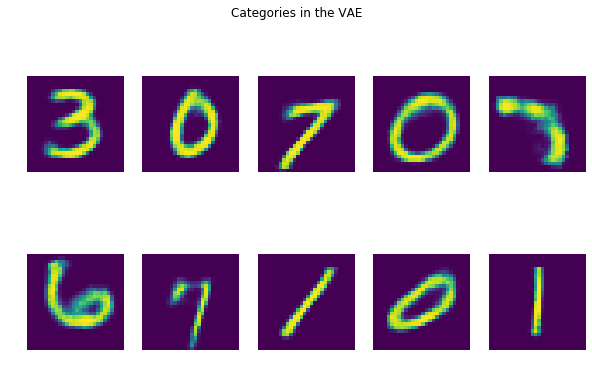

In [143]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(2, 5, figsize=(10, 6))

x = torch.zeros(10, 10).to(device)
for i in range(10):
    x[i, i]= 1
x_noise = torch.randn(10,2).to(device)

x = torch.cat((x,x_noise),1)


# x = torch.randn(10,20).to(device)
reconstruction = model.decoder(x)
r = reconstruction.data.cpu().numpy()

for i, ax in enumerate(axarr.flat):
    ax.imshow(r[i].reshape(28, 28), cmap="viridis")
    ax.axis("off")
    
plt.suptitle("Categories in the VAE")
plt.show()

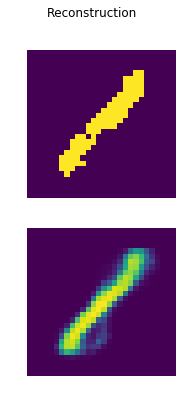

In [142]:
import matplotlib.pyplot as plt
f, axarr = plt.subplots(2, 1, figsize=(10, 6))

batch = next(iter(validation))[0][0].to(device)
reconstruction = model(batch.view(1,784))
r = reconstruction.data.cpu().numpy()
comparison = [batch, r]
for i, ax in enumerate(axarr.flat):
    ax.imshow(comparison[i].reshape(28, 28), cmap="viridis")
    ax.axis("off")
    
plt.suptitle("Reconstruction")
plt.show()